In [19]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, Gate
from qiskit import Aer
from typing import Union
from qiskit import assemble, transpile
from qiskit.circuit.library import TwoLocal
import torch
import numpy as np


In [34]:
# We will implement the efficientSU2 ansatz
def quanvolutionESU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular', insert_barrier=True):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('θ', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims

        qc.compose(entanglement(), range(N_dims), inplace=True)
        
        if (reps == 1 or i == reps-1):
            if insert_barrier: qc.barrier()
            for gate in gates:
                qc.compose(rotation(gate, start), range(N_dims), inplace=True)
                start += N_dims
        if insert_barrier: qc.barrier()
    
    return qc

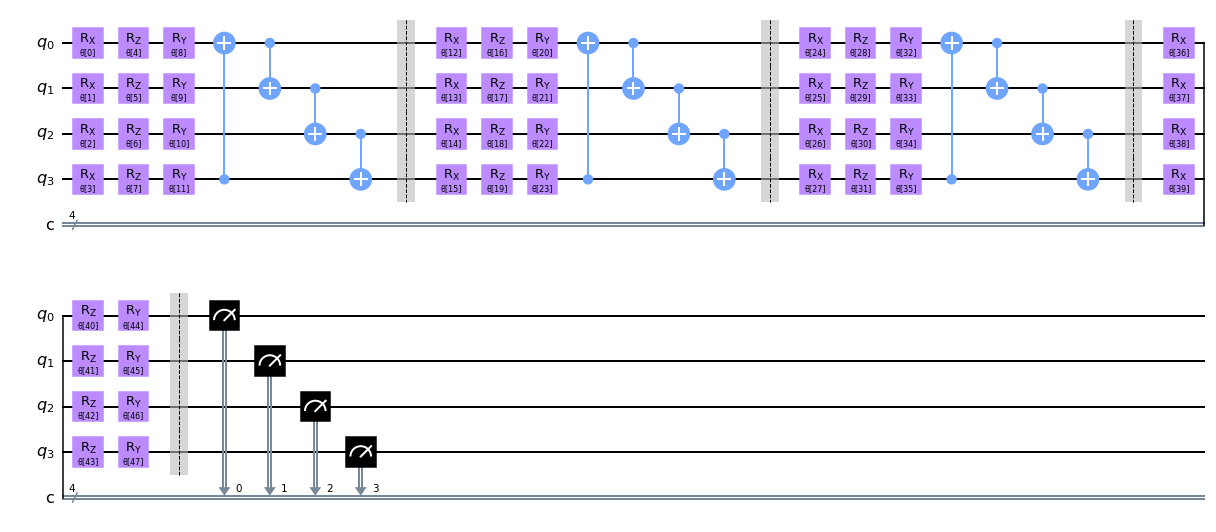

In [35]:
def randomLayer(numQbits, gates=['rx', 'rz', 'ry'], entanglement='linear', reps=1, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(numQbits)
    insert_barrier = False if to_gate else True 
    qc.compose(quanvolutionESU2(numQbits, gates=gates, entanglement=entanglement, reps=reps, 
                                insert_barrier=insert_barrier), inplace=True)
    return qc.to_gate(label="Random Layer") if to_gate else qc

n = 4
qc = QuantumCircuit(n,n)
qc.compose(randomLayer(n, reps=3, to_gate=False, entanglement='circular'), inplace=True)
qc.measure(range(n), range(n))
qc.draw('mpl')

In [46]:
class QC:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = QuantumCircuit(n_qubits).compose(randomLayer(n_qubits))
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = self._circuit.parameters
        print(self.theta)
        
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
    


In [47]:
backend = Aer.get_backend('aer_simulator')
qc = QC(1, backend, 1024)
print('Expected value for rotation pi {}'.format(qc.run([np.pi])[0]))
qc._circuit.draw('mpl')


ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5])])


TypeError: unhashable type: 'ParameterView'